In [1]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV,KFold,train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from time import time
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

heart = pd.read_csv("./Dataset/heart.csv")

In [2]:
heart.shape

(918, 12)

In [3]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
heart.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [5]:
heart.corr()

C:\Users\jonua\AppData\Local\Temp\ipykernel_17628\1516287138.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heart.corr()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.258612,0.282039
RestingBP,0.254399,1.000000,0.100893,0.070193,-0.112135,0.164803,0.107589
Cholesterol,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.050148,-0.232741
FastingBS,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.052698,0.267291
MaxHR,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.160691,-0.400421
Oldpeak,0.258612,0.164803,0.050148,0.052698,-0.160691,1.000000,0.403951
HeartDisease,0.282039,0.107589,-0.232741,0.267291,-0.400421,0.403951,1.000000


In [6]:
heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

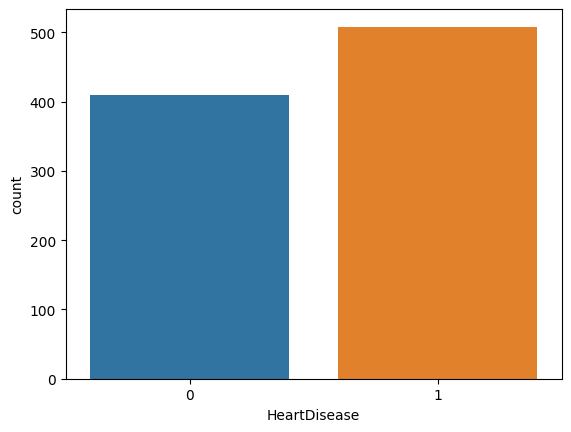

In [7]:
sns.countplot(x="HeartDisease", data=heart)

In [8]:
round(heart.groupby(["HeartDisease"])["Age"].agg(["min","max","mean"]),2)

,min,max,mean
HeartDisease,,,
0,28,76,50.55
1,31,77,55.90


In [9]:
def detect_outlier(feature):
    outliers = []
    data = heart[feature]
    mean = np.mean(data)
    std = np.std(data)
    
    for y in data:
        z_score = (y-mean)/std 
        if np.abs(z_score)>3:
            outliers.append(y)
    print("\nOutlier caps for %s:" % (feature))
    print("  -95p: %.1f / %s values exceed that" % (data.quantile(.95),len([i for i in data if i>data.quantile(.95)])))
    print("  -3sd: %.1f / %s values exceed that" % (mean+3*(std),len(outliers)))
    print("  -99p: %.1f / %s values exceed that" % (data.quantile(.99),len([i for i in data if i>data.quantile(.99)])))

In [10]:
# Determine what the upperbound should be for continuous features
for feat in ["Age","RestingBP","Cholesterol","MaxHR","Oldpeak"]:
    detect_outlier(feat)


Outlier caps for Age:
  -95p: 68.0 / 44 values exceed that
  -3sd: 81.8 / 0 values exceed that
  -99p: 74.0 / 7 values exceed that

Outlier caps for RestingBP:
  -95p: 160.0 / 43 values exceed that
  -3sd: 187.9 / 8 values exceed that
  -99p: 180.0 / 8 values exceed that

Outlier caps for Cholesterol:
  -95p: 331.3 / 46 values exceed that
  -3sd: 526.8 / 3 values exceed that
  -99p: 411.5 / 10 values exceed that

Outlier caps for MaxHR:
  -95p: 178.0 / 43 values exceed that
  -3sd: 213.1 / 1 values exceed that
  -99p: 186.0 / 9 values exceed that

Outlier caps for Oldpeak:
  -95p: 3.0 / 28 values exceed that
  -3sd: 4.1 / 7 values exceed that
  -99p: 4.0 / 6 values exceed that


In [11]:
# # Cap features
# heart["RestingBP"].clip(upper=heart["RestingBP"].quantile(.99), inplace=True)
# heart["Cholesterol"].clip(upper=heart["Cholesterol"].quantile(.99), inplace=True)
# heart["MaxHR"].clip(upper=heart["MaxHR"].quantile(.99), inplace=True)
# heart["Oldpeak"].clip(upper=heart["Oldpeak"].quantile(.99), inplace=True)

In [12]:
# Describe the dataframe again to make sure the capping was successful
heart.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


### Transform Skewed Features

C:\Users\jonua\AppData\Local\Temp\ipykernel_17628\4100663444.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(heart[feature], kde=False).set(xlabel=None)


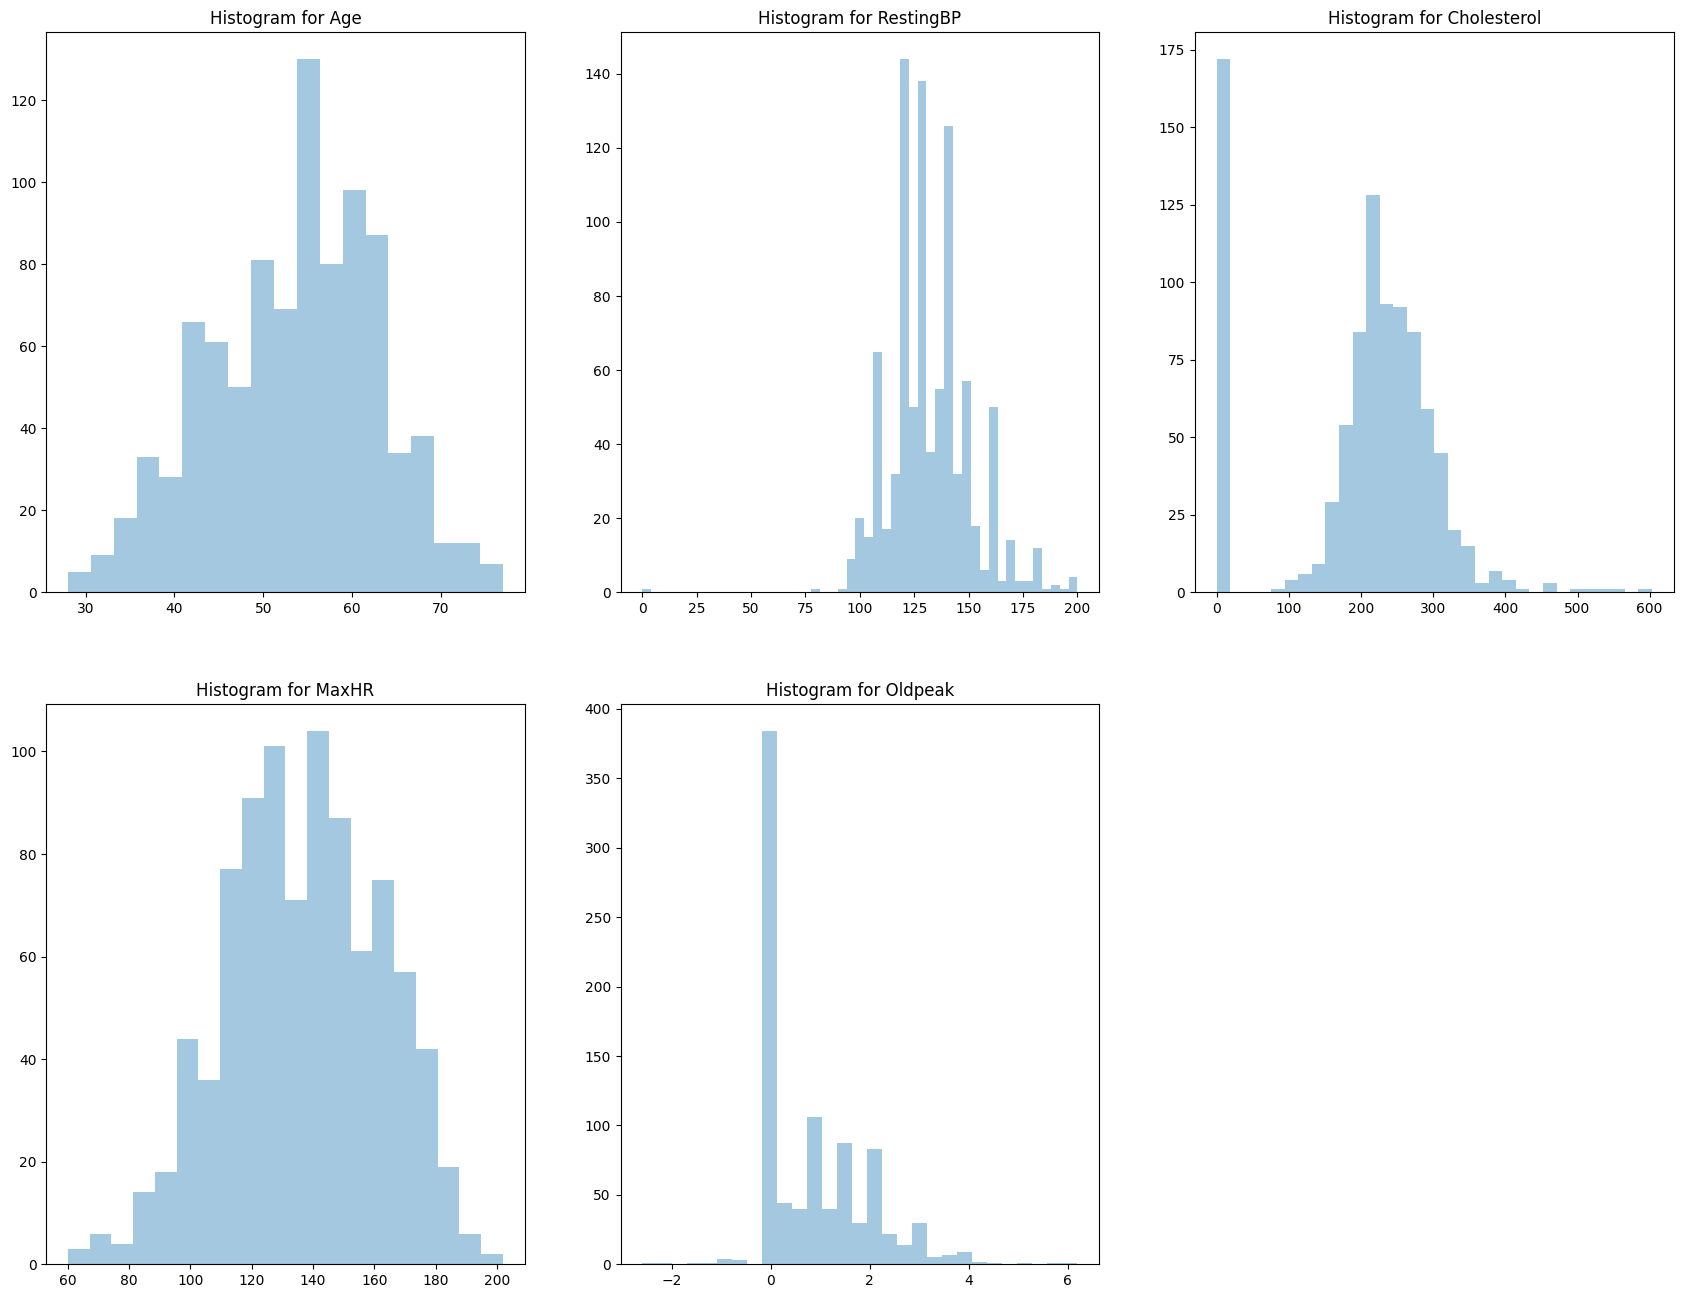

In [13]:
plt.figure(figsize=(21,16))
col = 1

for feature in ["Age","RestingBP","Cholesterol","MaxHR","Oldpeak"]:
    if col<6:
        plt.subplot(2,3,col)
        sns.distplot(heart[feature], kde=False).set(xlabel=None)
        plt.title("Histogram for %s" % (feature))
    col += 1

C:\Users\jonua\AppData\Local\Temp\ipykernel_17628\4100663444.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(heart[feature], kde=False).set(xlabel=None)


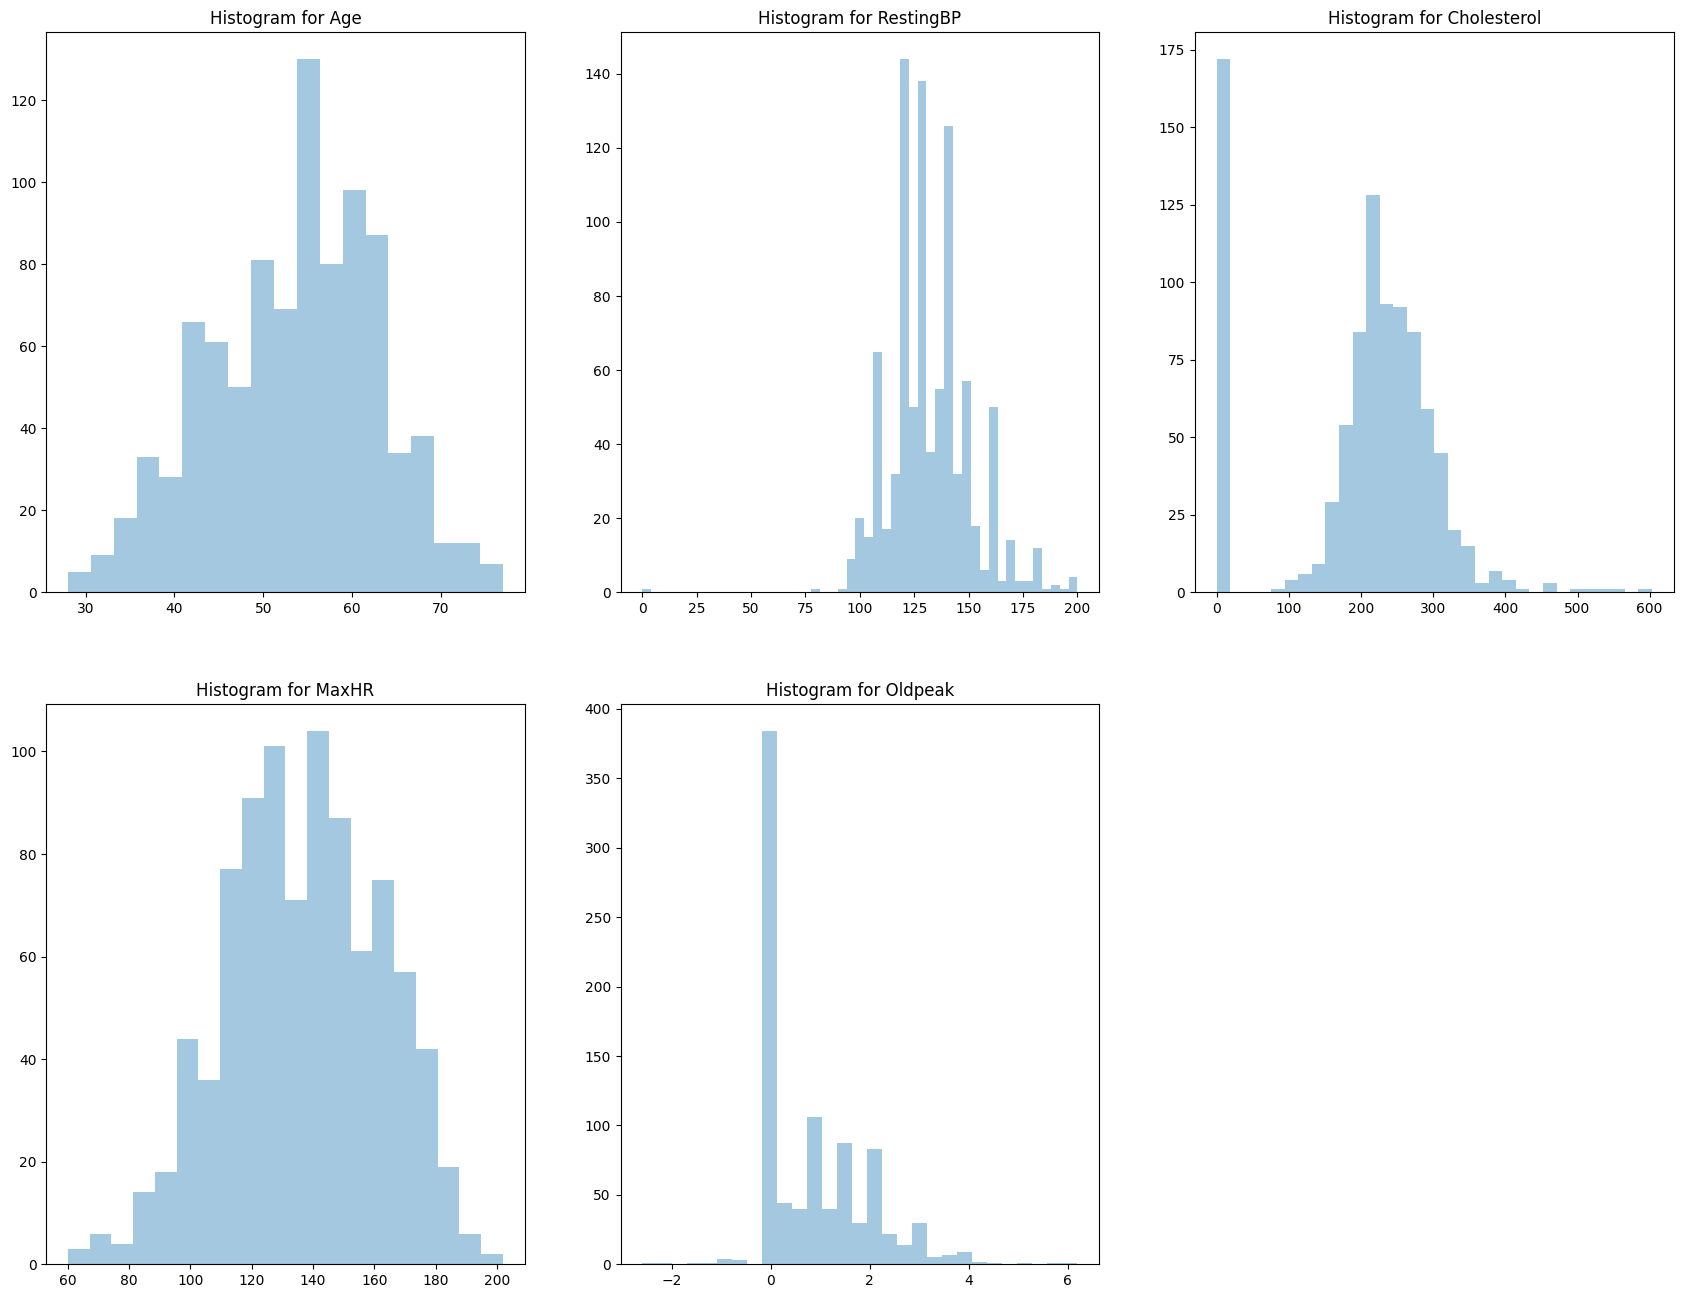

In [14]:
plt.figure(figsize=(21,16))
col = 1

for feature in ["Age","RestingBP","Cholesterol","MaxHR","Oldpeak"]:
    if col<6:
        plt.subplot(2,3,col)
        sns.distplot(heart[feature], kde=False).set(xlabel=None)
        plt.title("Histogram for %s" % (feature))
    col += 1

In [15]:
Gender = pd.get_dummies(heart['Sex']).drop(columns='F')
heart.drop(columns='Sex', inplace=True)
heart['Sex'] = Gender

In [16]:
heart['ChestPainType'].value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [17]:
ChestPainType = { 0 : 'ASY', 1 : 'NAP', 2 : 'ATA', 3 : 'TA' }


def Cat2Int(Arr_dict, Col):
    for i,val in Arr_dict.items():
        heart[Col].replace(val, i, inplace=True)
        

Cat2Int(ChestPainType, "ChestPainType")
heart.head()
        

,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex
0,40,2,140,289,0,Normal,172,N,0.0,Up,0,1
1,49,1,160,180,0,Normal,156,N,1.0,Flat,1,0
2,37,2,130,283,0,ST,98,N,0.0,Up,0,1
3,48,0,138,214,0,Normal,108,Y,1.5,Flat,1,0
4,54,1,150,195,0,Normal,122,N,0.0,Up,0,1


In [18]:
heart['RestingECG'].value_counts()

Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64

In [19]:
RestingECG = { 0 : 'Normal', 1 : 'LVH', 2 : 'ST'}

Cat2Int(RestingECG, "RestingECG")
heart.head()

,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex
0,40,2,140,289,0,0,172,N,0.0,Up,0,1
1,49,1,160,180,0,0,156,N,1.0,Flat,1,0
2,37,2,130,283,0,2,98,N,0.0,Up,0,1
3,48,0,138,214,0,0,108,Y,1.5,Flat,1,0
4,54,1,150,195,0,0,122,N,0.0,Up,0,1


In [20]:
heart['ST_Slope'].value_counts()

Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64

In [21]:
ST_Slope = { 0 : 'Flat', 1 : 'Up', 2 : 'Down'}

Cat2Int(ST_Slope, 'ST_Slope')
heart.head()

,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex
0,40,2,140,289,0,0,172,N,0.0,1,0,1
1,49,1,160,180,0,0,156,N,1.0,0,1,0
2,37,2,130,283,0,2,98,N,0.0,1,0,1
3,48,0,138,214,0,0,108,Y,1.5,0,1,0
4,54,1,150,195,0,0,122,N,0.0,1,0,1


In [22]:
ExerciseAngina = pd.get_dummies(heart['ExerciseAngina']).drop(columns='N')
heart.drop(columns='ExerciseAngina', inplace=True)
heart['ExerciseAngina'] = ExerciseAngina
heart

,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,Oldpeak,ST_Slope,HeartDisease,Sex,ExerciseAngina
0,40,2,140,289,0,0,172,0.0,1,0,1,0
1,49,1,160,180,0,0,156,1.0,0,1,0,0
2,37,2,130,283,0,2,98,0.0,1,0,1,0
3,48,0,138,214,0,0,108,1.5,0,1,0,1
4,54,1,150,195,0,0,122,0.0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,3,110,264,0,0,132,1.2,0,1,1,0
914,68,0,144,193,1,0,141,3.4,0,1,1,0
915,57,0,130,131,0,0,115,1.2,0,1,1,1
916,57,2,130,236,0,1,174,0.0,0,1,0,0


In [23]:
heart.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
ChestPainType,918.0,0.748366,0.931031,0.0,0.00,0.0,1.0,3.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
RestingECG,918.0,0.592593,0.793670,0.0,0.00,0.0,1.0,2.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
ST_Slope,918.0,0.567538,0.618959,0.0,0.00,0.0,1.0,2.0
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


### Standardize Features

In [24]:
Numerical_attr = ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# for i in heart.columns:
#     if heart[i].dtype != object:
#         Numerical_attr.append(i)
# Numerical_attr.remove('FastingBS')
# Numerical_attr.remove('Age')


In [25]:
print(Numerical_attr)
for i in Numerical_attr:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(heart[[i]])
    heart[i] = scaled

['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']


In [26]:
heart.head()

,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,Oldpeak,ST_Slope,HeartDisease,Sex,ExerciseAngina
0,40,2,0.410909,0.825070,0,0,1.382928,-0.832432,1,0,1,0
1,49,1,1.491752,-0.171961,0,0,0.754157,0.105664,0,1,0,0
2,37,2,-0.129513,0.770188,0,2,-1.525138,-0.832432,1,0,1,0
3,48,0,0.302825,0.139040,0,0,-1.132156,0.574711,0,1,0,1
4,54,1,0.951331,-0.034755,0,0,-0.581981,-0.832432,1,0,1,0


In [27]:
# Drop unnecccessary features and split into training/test sets
X = heart.drop(["HeartDisease"], axis=1)
Y = heart["HeartDisease"]
# kf = StratifiedKFold(n_splits=5)

features = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=40)

# for train_index,test_index in kf.split(X_train,Y_train):
#     X_ktrain,X_ktest = X_train.iloc[train_index],X_train.iloc[test_index]
#     y_ktrain,y_ktest = Y_train.iloc[train_index],Y_train.iloc[test_index]

<AxesSubplot:>

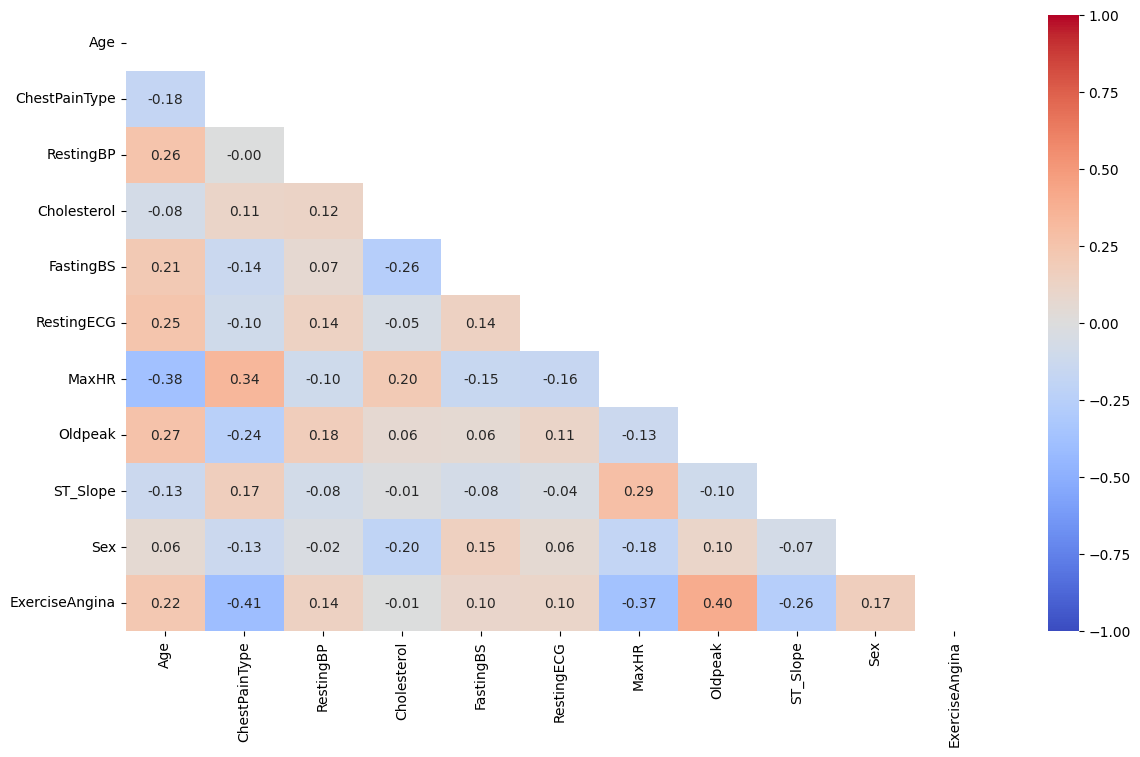

In [28]:
# Generate correlation matrix heat map
plt.figure(figsize=(14,8))
matrix = np.triu(X_train.corr())
sns.heatmap(X_train.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, center=0, cmap="coolwarm", mask=matrix)

HeartDisease variable is not highly correlated with any other feature. So, I take all the features for model implementation.
### Logistic Regression

In [29]:
# Conduct search for best params while running cross-validation (GridSearchCV)
parameters = {
    "C":[0.001,0.01,0.1,1.0,10,100,1000],
    "penalty":["l1","l2","elasticnet",None],
    "solver":["newton-cg","lbfgs","liblinear","sag","saga"]
}

lr_cv = GridSearchCV(LogisticRegression(), parameters, cv=5)
lr_cv.fit(X_train[features],y_train.values.ravel())

lr = lr_cv.best_estimator_
lr.fit(X_train[features],y_train.values.ravel())

c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

LogisticRegression(solver='liblinear')

### Random Forest

In [30]:
parameters = {
    "max_depth":[2,4,8,16,32],
    "n_estimators":[5,50,250,500]
}

rf_cv = GridSearchCV(RandomForestClassifier(), parameters, cv=5)
rf_cv.fit(X_train[features],y_train.values.ravel())

rf = rf_cv.best_estimator_
rf.fit(X_train[features],y_train.values.ravel())

RandomForestClassifier(max_depth=32, n_estimators=250)

### Adaptive Boosting

In [31]:
parameters = {
    "learning_rate":[0.01,0.1,1.0,10,100],
    "n_estimators":[5,50,250,500]
}

ada_cv = GridSearchCV(AdaBoostClassifier(), parameters, cv=5)
ada_cv.fit(X_train[features],y_train.values.ravel())

ada = ada_cv.best_estimator_
ada.fit(X_train[features],y_train.values.ravel())

c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:626: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:626: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
c:\Users\jonua\AppData\Loc

AdaBoostClassifier(learning_rate=0.01, n_estimators=500)

### Light Gradient Boosting Machine

In [32]:
parameters = {  
    "boosting_type":["gbdt","dart","goss","rf"],
    "learning_rate":[0.01,0.1,1.0,10,100],
    "max_depth":[2,4,8,16,32],
    "n_estimators":[5,50,250,500]
}

lgbm_cv = GridSearchCV(LGBMClassifier(), parameters, cv=5)
lgbm_cv.fit(X_train[features],y_train.values.ravel())

lgbm = lgbm_cv.best_estimator_
lgbm.fit(X_train[features],y_train.values.ravel())

c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
500 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "c:\Users\jonua\AppData

LGBMClassifier(boosting_type='goss', max_depth=2, n_estimators=50)

### K-Nearest Neighbor

In [33]:
parameters = {
    "algorithm":["ball_tree","kd_tree","brute"],
    "metric":["minkowski","euclidean","manhattan"],
    "n_neighbors":range(2,21),
    "weights":["uniform","distance"]
}

knn_cv = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
knn_cv.fit(X_train[features],y_train.values.ravel())

knn = knn_cv.best_estimator_
knn.fit(X_train[features],y_train.values.ravel())

KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_neighbors=14,
                     weights='distance')

### Support Vector Machine

In [34]:
parameters = {
    "C":[0.001,0.01,0.1,1.0,10,100,1000],
    "kernel":["linear","poly","rbf","sigmoid"]
}

svc_cv = GridSearchCV(SVC(), parameters, cv=5)
svc_cv.fit(X_train[features],y_train.values.ravel())

svc = svc_cv.best_estimator_
svc.fit(X_train[features],y_train.values.ravel())

SVC(C=1000, kernel='linear')

### Multi-layer Perceptron

In [35]:
parameters = {
    "activation":["identity","logistic","tanh","relu"],
    "hidden_layer_sizes":[(10,),(50,),(100,)],
    "max_iter":[5,10,15,20],
    "learning_rate":["constant","invscaling","adaptive"],
    "solver":["lbfgs","sgd","adam"]
}

mlp_cv = GridSearchCV(MLPClassifier(), parameters, cv=5)
mlp_cv.fit(X_train[features],y_train.values.ravel())

mlp = mlp_cv.best_estimator_
mlp.fit(X_train[features],y_train.values.ravel())

c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptr

MLPClassifier(hidden_layer_sizes=(50,), max_iter=20, solver='lbfgs')

### Stacking

In [36]:
estimators = [("lr",lr),("rf",rf),("ada",ada),("lgbm",lgbm),("knn",knn),("svc",svc),("mlp",mlp)]
parameters = {
    "passthrough":[True,False]
}

sc_cv = GridSearchCV(StackingClassifier(estimators=estimators, final_estimator=lr_cv.best_estimator_), parameters, cv=5)
sc_cv.fit(X_train[features],y_train.values.ravel())

sc = sc_cv.best_estimator_
sc.fit(X_train[features],y_train.values.ravel())

c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\jonua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptr

StackingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                               ('rf',
                                RandomForestClassifier(max_depth=32,
                                                       n_estimators=250)),
                               ('ada',
                                AdaBoostClassifier(learning_rate=0.01,
                                                   n_estimators=500)),
                               ('lgbm',
                                LGBMClassifier(boosting_type='goss',
                                               max_depth=2, n_estimators=50)),
                               ('knn',
                                KNeighborsClassifier(algorithm='ball_tree',
                                                     metric='manhattan',
                                                     n_neighbors=14,
                                                     weights='distance')),
                               ('svc', SVC(C=1000, kernel='linear')),
                               ('mlp',
                                MLPClassifier(hidden_layer_sizes=(50,),
                                              max_iter=20, solver='lbfgs'))],
                   final_estimator=LogisticRegression(solver='liblinear'))

### Evaluate Models On The Validation Set

In [37]:
# Evaluate all of our models on the validation set
models = [lr,rf,ada,lgbm,knn,svc,mlp,sc]
val_set = pd.DataFrame()
    
for i in models:
        start = time()
        pred = i.predict(X_train[features])
        end = time()        
        temp = pd.DataFrame(
                {
                    "Accuracy":("%0.3f" % (accuracy_score(y_train,pred))),
                    "F1":("%0.3f" % (f1_score(y_train,pred))),
                    "Precision":("%0.3f" % (precision_score(y_train,pred))),
                    "Recall":("%0.3f" % (recall_score(y_train,pred))),
                    "Latency":("%0.1fms" % ((end-start)*1000))
                }, index=[str(i).split("Classifier")[0].split("(")[0]]
        )
        val_set = pd.concat([val_set,temp])
val_set

,Accuracy,F1,Precision,Recall,Latency
LogisticRegression,0.866,0.877,0.874,0.879,2.0ms
RandomForest,1.000,1.000,1.000,1.000,30.2ms
AdaBoost,0.879,0.890,0.871,0.911,64.0ms
LGBM,0.910,0.918,0.901,0.937,1.0ms
KNeighbors,1.000,1.000,1.000,1.000,9.0ms
SVC,0.863,0.872,0.880,0.865,4.0ms
MLP,0.833,0.849,0.834,0.865,1.0ms
Stacking,0.947,0.951,0.946,0.957,122.7ms


### Evaluate Best Model On Test Set

In [38]:
# Evaluate our final model on the test set
test_set = pd.DataFrame()
    
for i in models:
        start = time()
        pred = i.predict(X_test[features])
        end = time()        
        temp = pd.DataFrame(
                {
                    "Accuracy":("%0.3f" % (accuracy_score(y_test,pred))),
                    "F1":("%0.3f" % (f1_score(y_test,pred))),
                    "Precision":("%0.3f" % (precision_score(y_test,pred))),
                    "Recall":("%0.3f" % (recall_score(y_test,pred))),
                    "Latency":("%0.1fms" % ((end-start)*1000))
                }, index=[str(i).split("Classifier")[0].split("(")[0]]
        )
        test_set = pd.concat([test_set,temp])
test_set

,Accuracy,F1,Precision,Recall,Latency
LogisticRegression,0.837,0.854,0.886,0.825,2.0ms
RandomForest,0.844,0.863,0.877,0.850,23.0ms
AdaBoost,0.862,0.880,0.891,0.869,52.0ms
LGBM,0.873,0.889,0.903,0.875,1.0ms
KNeighbors,0.833,0.853,0.875,0.831,5.0ms
SVC,0.804,0.822,0.868,0.781,3.0ms
MLP,0.822,0.843,0.863,0.825,2.0ms
Stacking,0.862,0.878,0.901,0.856,96.0ms


# Conclusion
By comparing different machine learning models based on accuracy score, it is found that **LGBM** classifier works best for this dataset.

In [40]:
import joblib

In [41]:
joblib.dump(lgbm, "Final Model.sav")

['Final Model.sav']